# Filtering and tracking EP4 Chembl-inspired ligands.

The purpose of this notebook is to filter ligands generated by Reinvent targeting EP4 and to track model metrics.

In [86]:
import pandas as pd
import os
from IPython import display
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
from itertools import product

from rdkit import Chem
from rdkit.Chem.rdRGroupDecomposition import RGroupDecompose
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdDepictor import Compute2DCoords
from rdkit.Chem.TemplateAlign import AlignMolToTemplate2D

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

import useful_rdkit_utils as uru

Local path to read reinvent results.

In [87]:
local_path_reinvent_results = '/home/corey/Documents/comp_chem/generation/2025-08-04_reinvent/'
reinvent_results_file = 'staged_learning_1.csv'

reinvent_output = pd.read_csv(f'{local_path_reinvent_results}/{reinvent_results_file}', delimiter=',')

In [88]:
pd.set_option('display.max_columns', None)

reinvent_output.tail()

,Agent,Prior,Target,Score,SMILES,SMILES_state,Scaffold,QED,QED (raw),gnina score,gnina score (raw),MW,MW (raw),SlogP (RDKit),SlogP (RDKit) (raw),TPSA,TPSA (raw),Number of stereo centers,Number of stereo centers (raw),Number of HB acceptors (Lipinski),Number of HB acceptors (Lipinski) (raw),Number of HB donors (Lipinski),Number of HB donors (Lipinski) (raw),Number of rotatable bonds,Number of rotatable bonds (raw),Number of Heavy atoms,Number of Heavy atoms (raw),Molecular Volume (RDKit),Molecular Volume (RDKit) (raw),SA score,SA score (raw),Alerts,Alerts (raw),matchting_patterns (Alerts),step
2811,26.5979,26.7260,-24.9153,0.003621,Cc1c2c(=N)[nH][nH]c2nc2c1c(=O)c1ccccc1n2C,1,N=c1[nH][nH]c2nc3[nH]c4ccccc4c(=O)c3cc12,0.427395,0.4274,-6.50921,-6.5092,0.999328,279.303,0.860458,1.6840,1.0,90.32,1.0,0.0,1.0,4.0,0.053240,3.0,0.996848,0.0,0.996183,21.0,0.999741,234.840,0.895217,3.1367,1.0,1.0,[],22
2812,47.3113,48.1223,-48.1223,0.000000,CC(=O)Nc1ccc2c(c1)SC(c1cnc3cc(-c4ccccc4)cc(CC(...,1,c1ccc(-c2ccc3nc(C4Cc5ccccc5S4)cnc3c2)cc1,0.000000,0.0000,0.00000,0.0000,0.000000,0.000,0.000000,0.0000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0000,0.0,0.0,"['C(=[O,S])[O,S]', '[OH]']",22
2813,23.2092,24.0395,-21.9094,0.004260,c1cnc2nc(-c3ccncc3)[nH]c(=NC3CCNC3)c2c1,1,c1cnc2nc(-c3ccncc3)[nH]c(=NC3CCNC3)c2c1,0.745592,0.7456,-8.61425,-8.6143,0.999798,292.346,0.984176,1.2825,1.0,78.85,1.0,1.0,1.0,5.0,0.500000,2.0,0.990099,2.0,0.995380,22.0,0.999299,260.760,0.836168,3.5842,1.0,1.0,[],22
2814,23.9173,24.4579,-24.4579,0.000000,Oc1cnc(Cl)cc1C1CCCC1,1,c1cc(C2CCCC2)ccn1,0.000000,0.0000,0.00000,0.0000,0.000000,0.000,0.000000,0.0000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0000,0.0,0.0,['[OH]'],22
2815,28.4628,28.3592,-26.6081,0.003502,[O-][n+]1cc(Cl)cc2c1nc1sccn12,1,c1c[nH+]c2nc3sccn3c2c1,0.432895,0.4329,-4.35007,-4.3501,0.913991,225.660,0.720151,1.8358,1.0,44.24,1.0,0.0,1.0,4.0,0.996848,0.0,0.996848,0.0,0.999001,14.0,0.999983,164.256,0.846801,3.5150,1.0,1.0,[],22


Exclude compounds that were not docked.

In [89]:
reinvent_output = reinvent_output[reinvent_output['gnina score'] < 0]

In [90]:
reinvent_output['smiles_canonical'] = reinvent_output['SMILES'].apply(lambda x: Chem.CanonSmiles(x))

In [91]:
descriptors = [
                'MW (raw)', 
                'TPSA (raw)', 
                'SlogP (RDKit) (raw)',
                'Number of HB donors (Lipinski) (raw)',
                'QED (raw)',
                 'Number of rotatable bonds (raw)',
                 'Number of HB donors (Lipinski) (raw)',
                 'Number of HB acceptors (Lipinski) (raw)',
                 'Number of Heavy atoms (raw)',
                'gnina score',
            ]

In [92]:
for descriptor in descriptors:
    reinvent_output[descriptor] = reinvent_output[descriptor].astype(float)

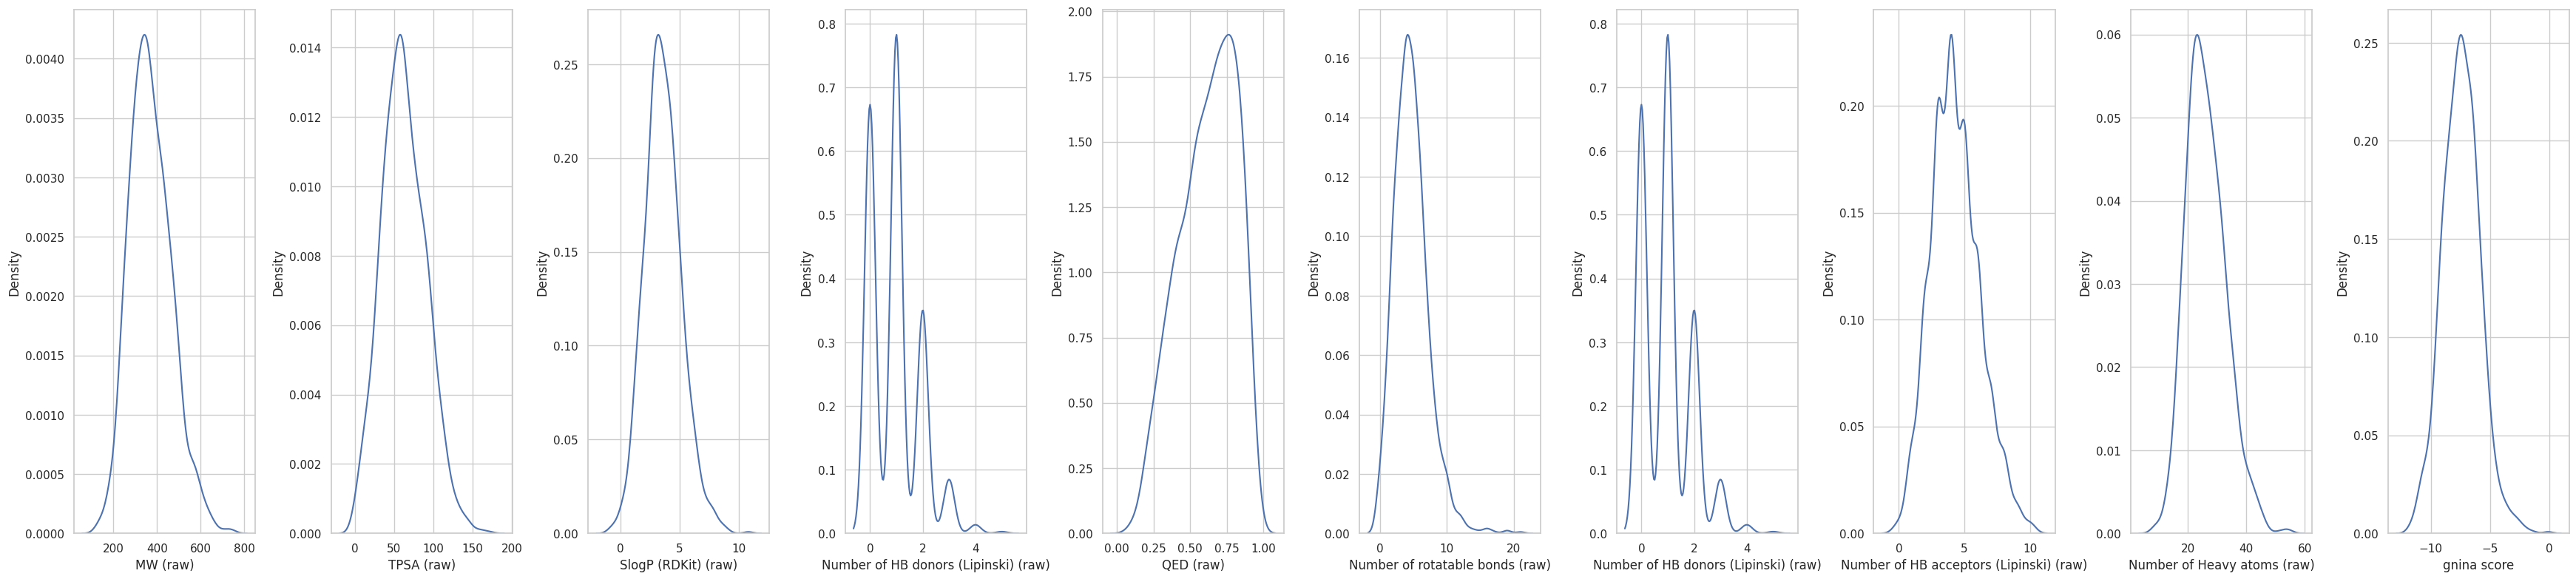

In [93]:
sns.set_theme(style="whitegrid", palette="deep")

f, axs = plt.subplots(1, len(descriptors), figsize=(35, 8), sharey=False)
for ax, col in zip(axs, descriptors):
    sns.kdeplot(data=reinvent_output, x=col, ax=ax)
f.tight_layout()

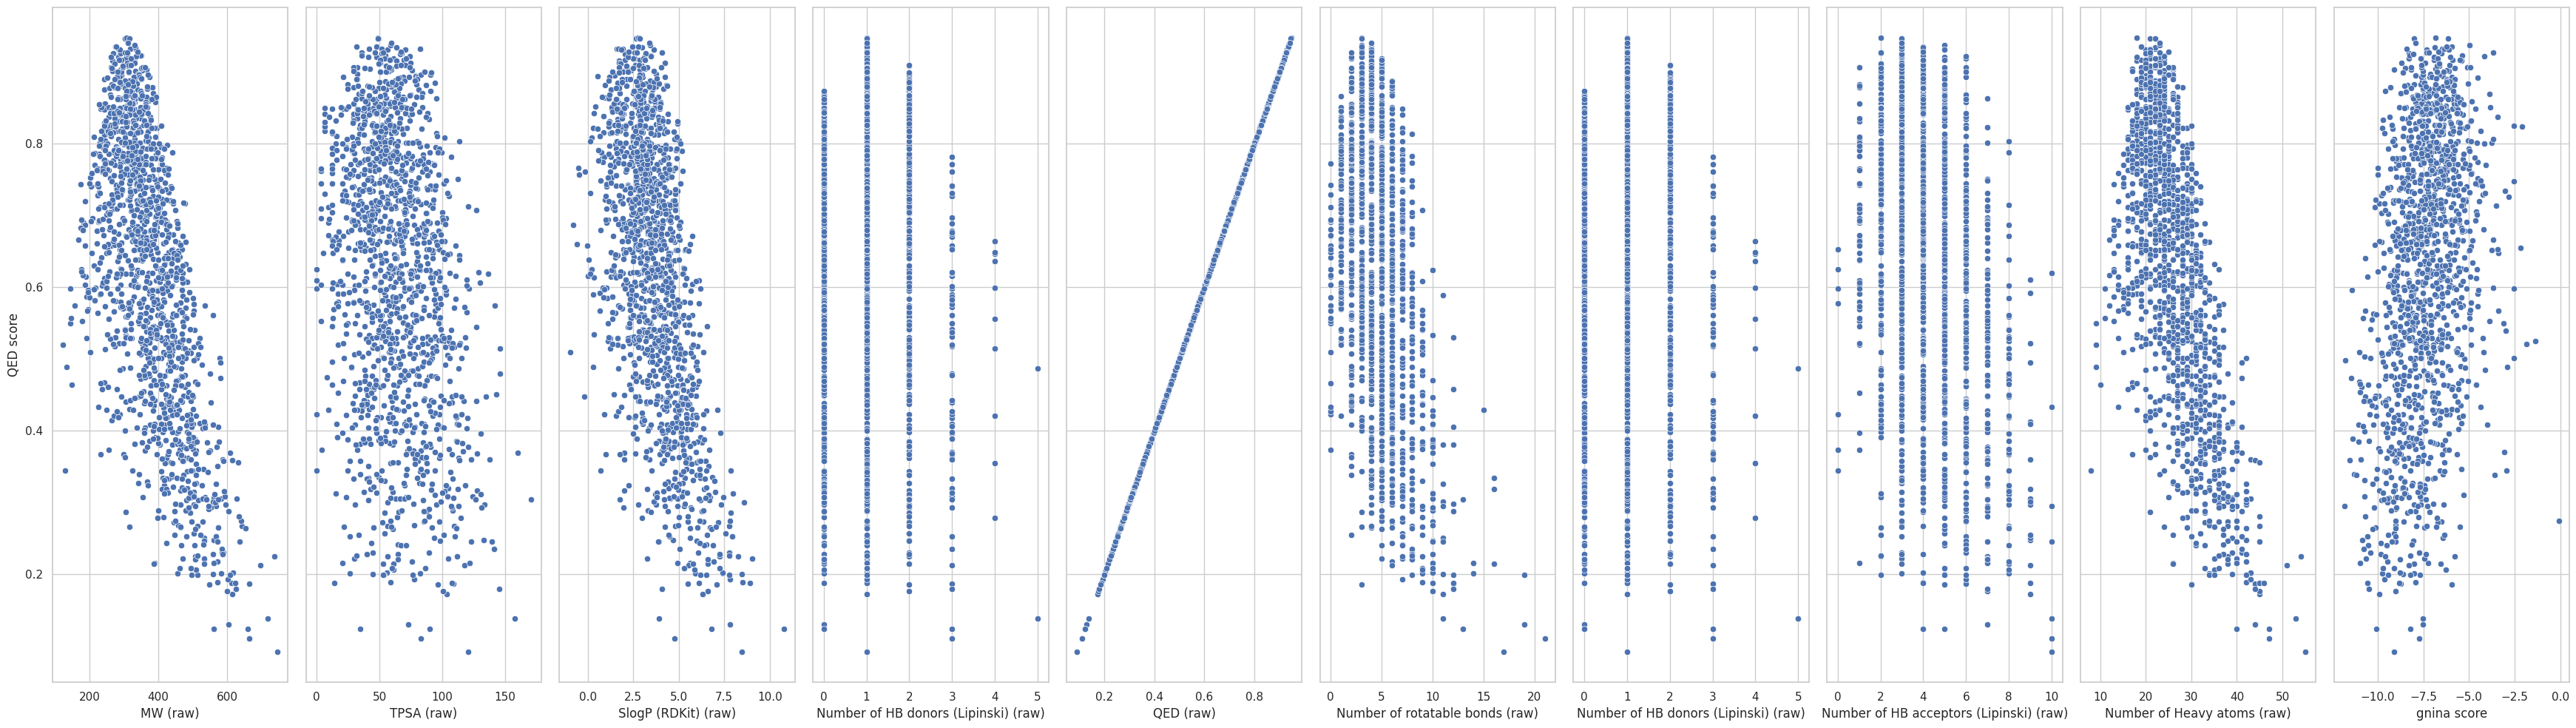

In [94]:
sns.set_theme(style="whitegrid", palette="deep")

# sns.violinplot(data=reinvent_output, y='MW (raw)', x="SMILES_state")

f, axs = plt.subplots(1, len(descriptors), figsize=(35, 10), sharey=True)
for ax, col in zip(axs, descriptors):
    sns.scatterplot(data=reinvent_output, x=col, y='QED (raw)', ax=ax)
f.tight_layout()

for ax in axs.flat:
    ax.set(ylabel='QED score')
    ax.label_outer()

Only keep high-scoring compounds and those that meet other physchem criteria (add / delete filters as necessary).

In [99]:
high_scoring_compounds = reinvent_output[
    (reinvent_output['QED (raw)'] > 0.3) &
    (reinvent_output['TPSA (raw)'] < 100) &
    (reinvent_output['MW (raw)'] > 400) &
    (reinvent_output['SlogP (RDKit) (raw)'] < 5)
    # (reinvent_output['Number of rotatable bonds (raw)'] < 5)
    # (reinvent_output['Number of HB donors (Lipinski) (raw)'] < 3) &
    # (reinvent_output['Number of HB acceptors (Lipinski) (raw)'] < 6)
    # (reinvent_output['r_group_canonical'].str.contains('\*C\(\=O\)') == False)
    # (reinvent_output['gnina score'] < -10)
]

In [100]:
len(high_scoring_compounds)

230

In [101]:
for_docking = high_scoring_compounds.loc[high_scoring_compounds.groupby(['smiles_canonical'])['QED (raw)'].idxmax()]

In [102]:
for_docking = for_docking.reset_index(drop=True)

In [103]:
len(for_docking)

230

In [104]:
for_docking = for_docking.sort_values(by='QED (raw)', ascending=False)

Show filtered generated compounds.

/home/corey/miniconda3/envs/docking_md/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


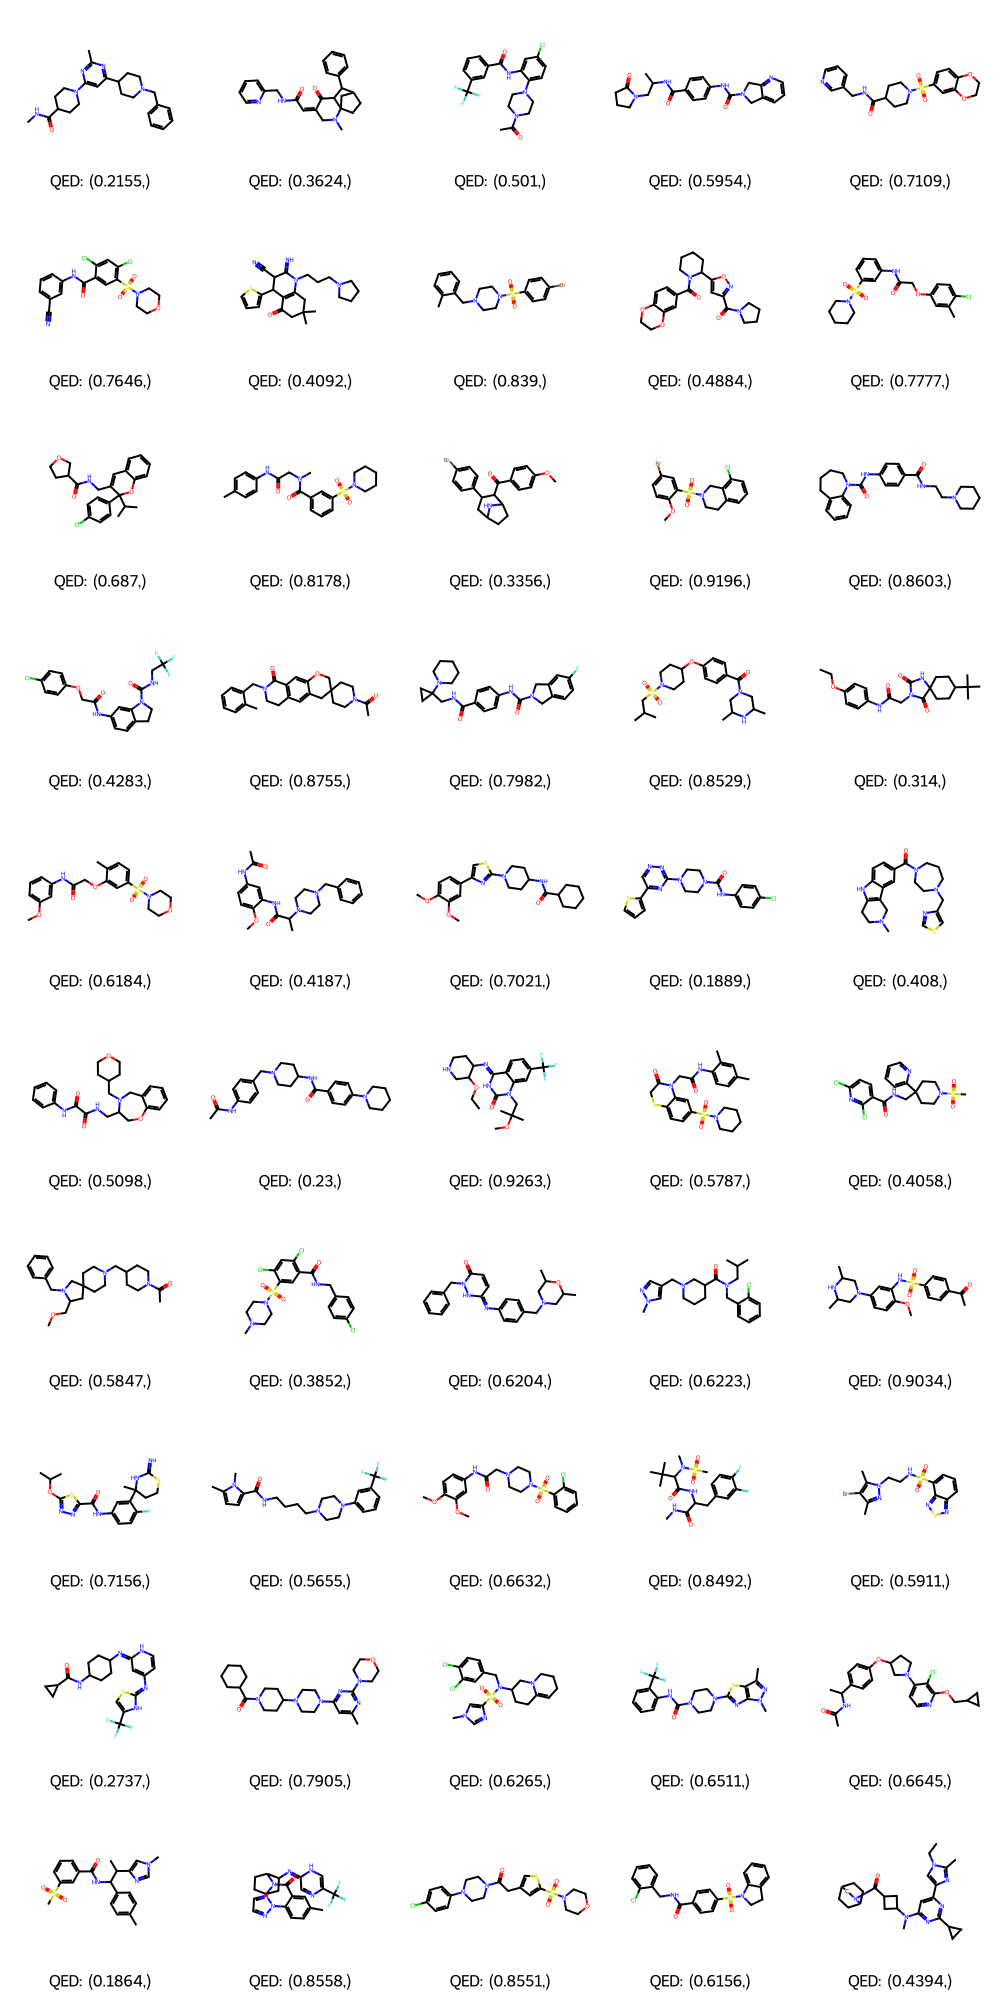

In [105]:
from rdkit.Chem import Draw
from rdkit import Chem

Draw.MolsToGridImage(
    mols=[Chem.MolFromSmiles(s) for s in list(for_docking.smiles_canonical)],
    legends=[
            (" ".join(["QED:", str(i)])) for i in zip(reinvent_output['QED (raw)'])
        ],
    molsPerRow=5,
    maxMols=50,
)

In [106]:
high_scoring_compounds = high_scoring_compounds.reset_index(drop=True)

In [107]:
# for_docking.SMILES.to_list()

# Tracking Reinvent metrics.

* We can track metrics to see if the model is learning and generating compounds that improve based on the scoring function. 
* As this run is only 50 steps, this usually isn't enough for the model to learn effectively, so we don't expect significant learning to occur. 
* Production runs should be > 500 epochs to see improvements in generated compounds.
* Especially the case if you plan to reuse the model for subsequent runs.

In [108]:
reinvent_output.head(1)

,Agent,Prior,Target,Score,SMILES,SMILES_state,Scaffold,QED,QED (raw),gnina score,gnina score (raw),MW,MW (raw),SlogP (RDKit),SlogP (RDKit) (raw),TPSA,TPSA (raw),Number of stereo centers,Number of stereo centers (raw),Number of HB acceptors (Lipinski),Number of HB acceptors (Lipinski) (raw),Number of HB donors (Lipinski),Number of HB donors (Lipinski) (raw),Number of rotatable bonds,Number of rotatable bonds (raw),Number of Heavy atoms,Number of Heavy atoms (raw),Molecular Volume (RDKit),Molecular Volume (RDKit) (raw),SA score,SA score (raw),Alerts,Alerts (raw),matchting_patterns (Alerts),step,smiles_canonical
3,30.5832,30.5832,-29.0999,0.002966,CCCCCCCCCC(Cl)CCCCCC(=O)N1CC[N+](C)(C)CC1,1,C1C[NH2+]CCN1,0.21549,0.2155,-7.25909,-7.2591,0.999967,388.06,0.0,5.6036,0.998747,20.31,1.0,1.0,1.0,1.0,0.996848,0.0,0.090909,14.0,0.990099,26.0,0.819997,410.488,0.890378,3.1806,1.0,1.0,[],1,CCCCCCCCCC(Cl)CCCCCC(=O)N1CC[N+](C)(C)CC1


In [109]:
reinvent_output_filtered = reinvent_output[reinvent_output['step'] < 500]

In [110]:
descriptors = [
                'step',
                'MW', 
                'TPSA', 
                # 'SlogP (RDKit)',
                'Number of HB donors (Lipinski)',
                'QED',
                'Number of rotatable bonds',
                'Number of HB donors (Lipinski)',
                #  'SA score (raw)',
                # 'gnina score',
            ]

In [111]:
reinvent_output_filtered = reinvent_output_filtered[descriptors]

In [112]:
df_arranged = reinvent_output_filtered.melt(id_vars=['step'], var_name='Descriptor', value_name='norm_value')

In [113]:
sns.set_theme(rc={'figure.figsize':(11,4.1)}, style="whitegrid", palette="deep")

* 'Target' (augNLL) vs epoch. 
* augNLL calculated from model should be trending toward smaller (less negative) values if the model is learning to generate better compounds. 
* As expected, no indication of significant improvement in generated compounds for 50 epochs.

<Axes: xlabel='step', ylabel='Target'>

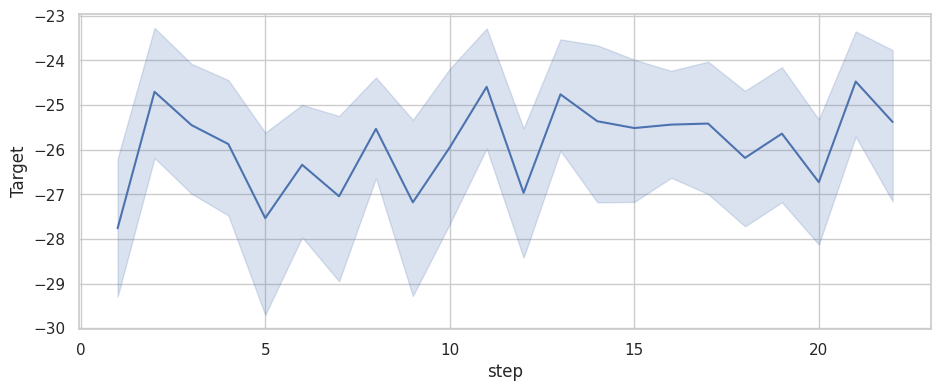

In [114]:
sns.lineplot(reinvent_output, x='step', y='Target')

Again, as expected, no indication of significant variance in normalised physchem values for generated compounds.

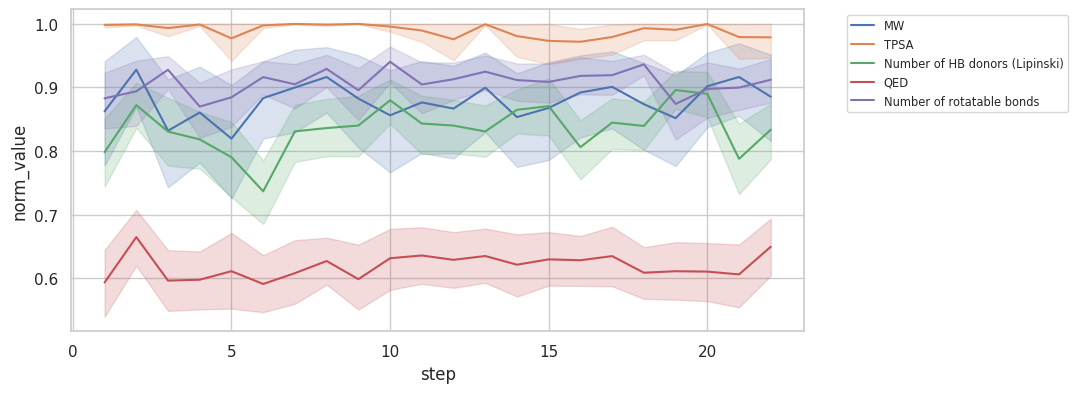

In [116]:
sns.lineplot(data=df_arranged, x="step", y='norm_value', hue='Descriptor')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.tight_layout()

plt.show()

We can also look at the raw values.

In [117]:
descriptors_raw = [
                'step',
                'MW (raw)', 
                'TPSA (raw)', 
                'SlogP (RDKit)',
                'QED (raw)',
                'Number of rotatable bonds (raw)',
                'Number of HB donors (Lipinski) (raw)',
                #  'SA score (raw)',
                # 'gnina score',
            ]

In [118]:
reinvent_output_raw = reinvent_output[descriptors_raw]

In [119]:
reinvent_output_raw = reinvent_output_raw[reinvent_output_raw['step'] < 500]

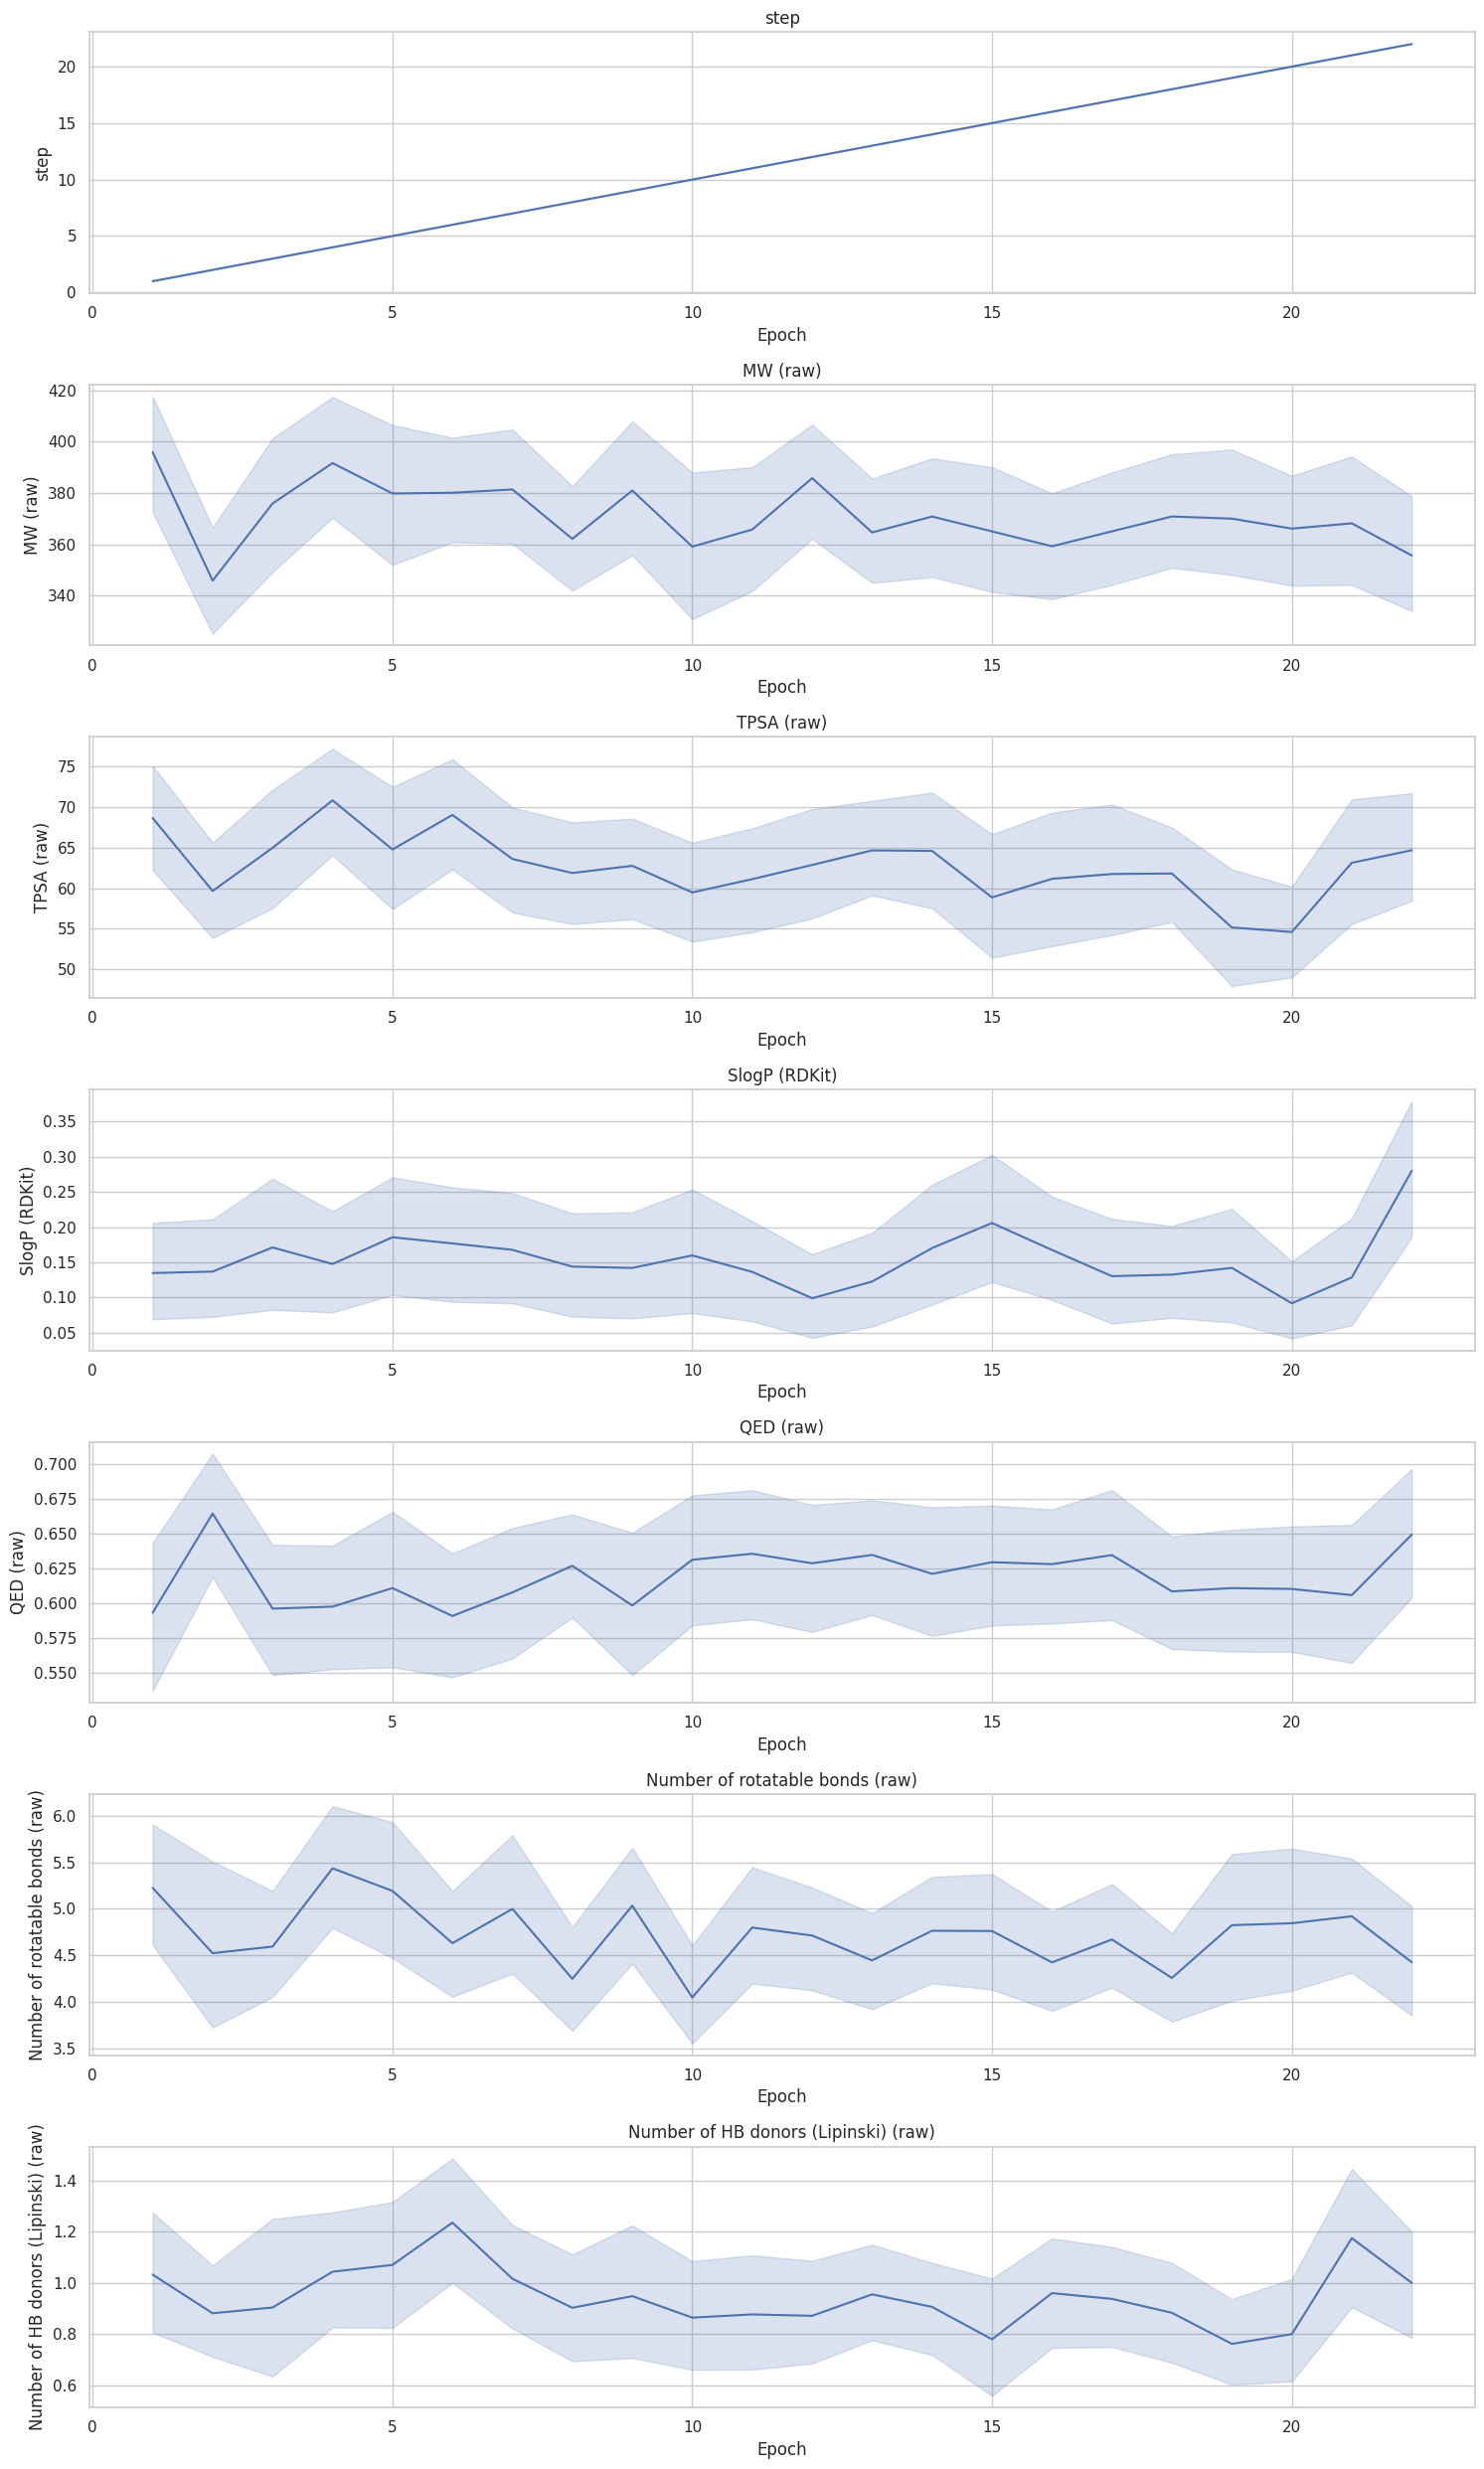

In [120]:
# Set up subplots
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))  # Adjust layout as needed

# Loop over variables and axes
for ax, var in zip(axes, descriptors_raw):
    sns.lineplot(data=reinvent_output_raw, x='step', y=var, ax=ax)
    ax.set_title(f'{var}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()